# ERNet: CNN segmentation model for 

### Packages

In [1]:
import math
import os
import time 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from models import GetModel
from datahandler import GetDataloaders

from plotting import testAndMakeCombinedPlots


### Train function

In [11]:
def train(dataloader, validloader, net, opt, nepoch=10):
    
    start_epoch = 0
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=opt.lr)

    useGPU = torch.cuda.is_available() and not opt.cpu
    
    if useGPU:
        loss_function.cuda()


    if len(opt.weights) > 0: # load previous weights?
        checkpoint = torch.load(opt.weights)
        print('loading checkpoint',opt.weights)
        if opt.undomulti:
            checkpoint['state_dict'] = remove_dataparallel_wrapper(checkpoint['state_dict'])
        else:
            net.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            start_epoch = checkpoint['epoch']


    if len(opt.scheduler) > 0:
        stepsize, gamma = int(opt.scheduler.split(',')[0]), float(opt.scheduler.split(',')[1])
        scheduler = optim.lr_scheduler.StepLR(optimizer, stepsize, gamma=gamma, last_epoch=start_epoch-1)

    count = 0
    opt.t0 = time.perf_counter()

    for epoch in range(start_epoch, nepoch):
        mean_loss = 0

        for i, bat in enumerate(dataloader):
            lr, hr = bat[0], bat[1]
            hr = hr[:,0] # no need for colour channel, just holds holds integers for classes
            optimizer.zero_grad()

            if useGPU:
                sr = net(lr.cuda())
                hr_classes = torch.round((opt.nch_out-1)*hr).long().cuda()
            else:
                sr = net(lr)
                hr_classes = torch.round((opt.nch_out-1)*hr).long()

            loss = loss_function(sr, hr_classes)

            loss.backward()
            optimizer.step()
            
            
            ######### Status and display #########
            mean_loss += loss.data.item()
            print('\r[%d/%d][%d/%d] Loss: %0.6f' % (epoch+1,nepoch,i+1,len(dataloader),loss.data.item()),end='')
            
            count += 1
            if opt.log and count*opt.batchSize // 1000 > 0:
                t1 = time.perf_counter() - opt.t0
                mem = torch.cuda.memory_allocated()
                print(epoch, count*opt.batchSize, t1, mem, mean_loss / count, file=opt.train_stats)
                opt.train_stats.flush()
                count = 0



        # ---------------- Scheduler -----------------
        if len(opt.scheduler) > 0:
            scheduler.step()
            for param_group in optimizer.param_groups:
                print('\nLearning rate',param_group['lr'])
                break        


        # ---------------- Printing -----------------
        print('\nEpoch %d done, %0.6f' % (epoch,(mean_loss / len(dataloader))))
        print('\nEpoch %d done, %0.6f' % (epoch,(mean_loss / len(dataloader))),file=opt.fid)
        opt.fid.flush()
        if opt.log:
            opt.writer.add_scalar('data/mean_loss', mean_loss / len(dataloader), epoch)


        # ---------------- TEST -----------------
        if (epoch + 1) % opt.testinterval == 0:
            testAndMakeCombinedPlots(net,validloader,opt,epoch)
            # if opt.scheduler:
                # scheduler.step(mean_loss / len(dataloader))

        if (epoch + 1) % opt.saveinterval == 0:
            # torch.save(net.state_dict(), opt.out + '/prelim.pth')
            checkpoint = {'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict() }
            torch.save(checkpoint, opt.out + '/prelim.pth')
    
    checkpoint = {'epoch': nepoch,
    'state_dict': net.state_dict(),
    'optimizer' : optimizer.state_dict() }
    torch.save(checkpoint, opt.out + '/final.pth')



### Options

In [20]:
import argparse
opt = argparse.Namespace()

opt.root = 'trainingdata/partitioned_256'
opt.out = 'trained_models/ERNet_rcan-rg5-t'
opt.imageSize = 256 
opt.model = 'rcan'
opt.nch_in = 1 
opt.nch_out = 2 
opt.ntrain = 480 
opt.ntest = 20 
opt.batchSize = 10 # reduce if not enough VRAM 
opt.batchSize_test = 1
opt.n_resgroups = 2
opt.n_resblocks = 5
opt.n_feats = 48
opt.narch = 0
opt.reduction = 16
opt.lr = 0.0001 
opt.workers = 4
opt.scheduler = 20,0.5 
opt.nepoch = 5 # this value is very low, just for demonstrative purposes
opt.cpu = False
opt.multigpu = False
opt.log = False
opt.test = False
opt.saveinterval = 10
opt.testinterval = 1
opt.plotinterval = 1
opt.weights = ''
opt.dataset = 'pickledataset'
opt.scheduler = ''
opt.task = 'segment'

### Start training

In [21]:
try:
    os.makedirs(opt.out)
except IOError:
    pass

opt.fid = open(opt.out + '/log.txt','w')
print(opt)
print(opt,'\n',file=opt.fid)

dataloader, validloader = GetDataloaders(opt)        
net = GetModel(opt)

if opt.log:
    opt.train_stats = open(opt.out.replace('\\','/') + '/train_stats.csv','w')
    opt.test_stats = open(opt.out.replace('\\','/') + '/test_stats.csv','w')
    print('iter,nsample,time,memory,meanloss',file=opt.train_stats)
    print('iter,time,memory,psnr,ssim',file=opt.test_stats)

import time
t0 = time.perf_counter()
if not opt.test:
    train(dataloader, validloader, net, opt, nepoch=opt.nepoch)
else:
    if len(opt.weights) > 0: # load previous weights?
        checkpoint = torch.load(opt.weights)
        print('loading checkpoint',opt.weights)
        if opt.undomulti:
            checkpoint['state_dict'] = remove_dataparallel_wrapper(checkpoint['state_dict'])
        net.load_state_dict(checkpoint['state_dict'])
        print('time: ',time.perf_counter()-t0)
    testAndMakeCombinedPlots(net,validloader,opt)
print('time: ',time.perf_counter()-t0)

Namespace(batchSize=10, batchSize_test=1, cpu=False, dataset='pickledataset', fid=<_io.TextIOWrapper name='trained_models/ERNet_rcan-rg5-t/log.txt' mode='w' encoding='cp1252'>, imageSize=256, log=False, lr=0.0001, model='rcan', multigpu=False, n_feats=48, n_resblocks=5, n_resgroups=2, narch=0, nch_in=1, nch_out=2, nepoch=5, ntest=20, ntrain=480, out='trained_models/ERNet_rcan-rg5-t', plotinterval=1, reduction=16, root='trainingdata/partitioned_256', saveinterval=10, scheduler='', task='segment', test=False, testinterval=1, weights='', workers=4)
[1/5][48/48] Loss: 0.452035
Epoch 0 done, 0.471579
Testing of 20 samples complete. bc: 6.93 dB / 0.0993, sr: 7.94 dB / 0.7188
[2/5][48/48] Loss: 0.401375
Epoch 1 done, 0.419491
Testing of 20 samples complete. bc: 6.93 dB / 0.0993, sr: 7.94 dB / 0.7188
[3/5][48/48] Loss: 0.358563
Epoch 2 done, 0.399084
Testing of 20 samples complete. bc: 6.93 dB / 0.0993, sr: 7.94 dB / 0.7188
[4/5][48/48] Loss: 0.357655
Epoch 3 done, 0.381678
Testing of 20 sampl

#### Plot a validation result

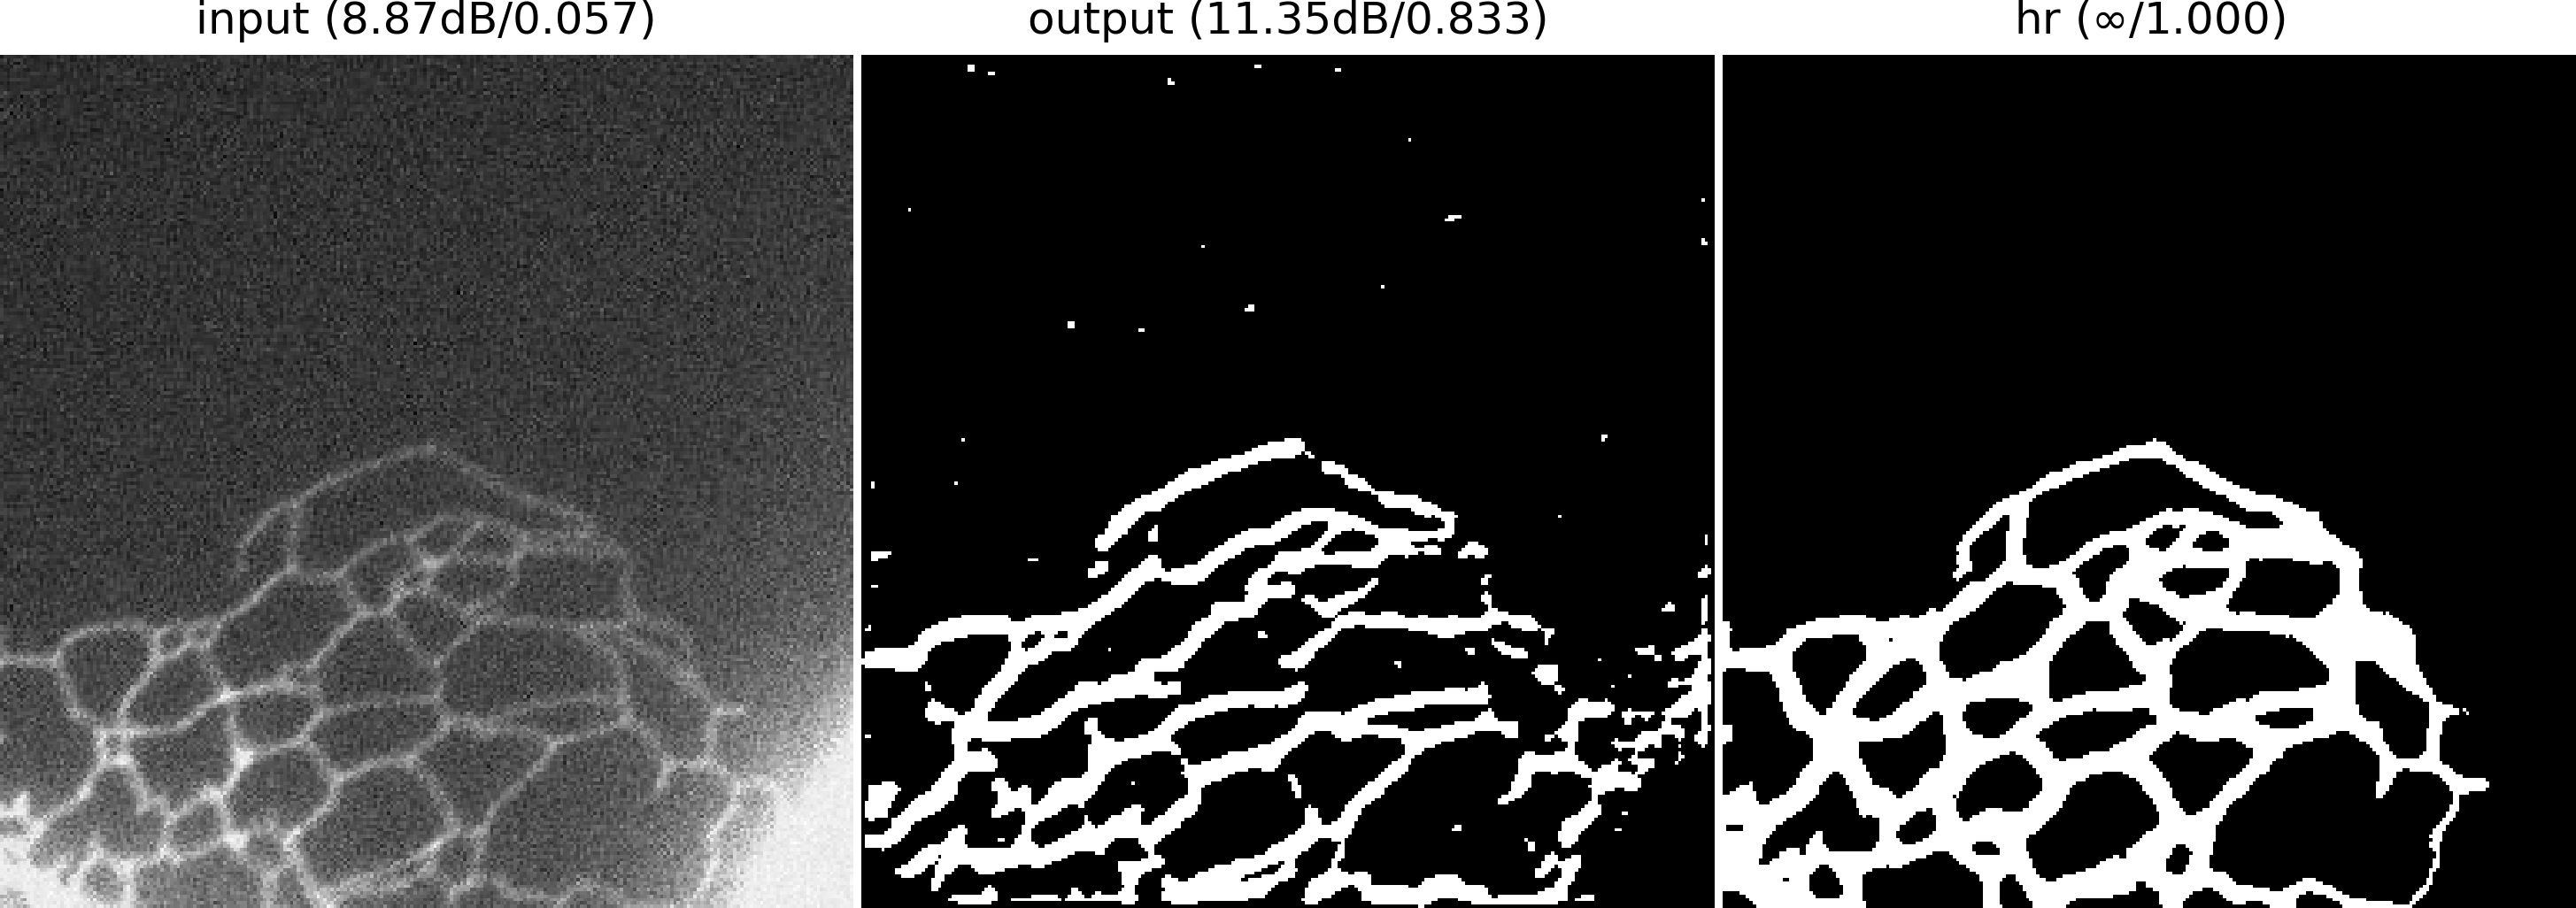

In [25]:
from PIL import Image

Image.open('trained_models/ERNet_rcan-rg5-t/combined_epoch4_17.png')

Model has only trained for 5 epochs, so it is far from having converged fully. The model could also be made deeper - the example given here has relatively few layers. 